# Candidate models for ML finance

In [140]:
# sum(df_plot['Diff Close'])
# plt.figure(figsize = ( 20 , 10 ))
#   # Set title for figure
# plt.title( 'Ridge Regression prediction vs actual close price' , size = 24 )
   
# sns.lineplot(x='Date', y='value', hue='variable', 
#              data=pd.melt(df_plot, ['Date']))
# plt.ylabel("Price")
# # Display figure
# plt.show() 

237.44627551216513

In [11]:

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from pandas_datareader import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
def Kalman_Filter(param,*args):
 S = Y.shape[0]
 S = S + 1
 "Initialize Params:"
 Z = param[0]
 T = param[1]
 H = param[2]
 Q = param[3]
 "Kalman Filter Starts:"
 u_predict = np.zeros(S)
 u_update = np.zeros(S)
 P_predict = np.zeros(S)
 P_update = np.zeros(S)
 v = np.zeros(S)
 F = np.zeros(S)
 KF_Dens = np.zeros(S)
 for s in range(1,S):
  if s == 1: 
    P_update[s] = 900
    P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
  else: 
    F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
    v[s]=Y[s-1]-Z*u_predict[s-1]   
    u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
    u_predict[s] = T*u_update[s]
    P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
    P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    KF_Dens[s] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]      
    
    Likelihood = sum(KF_Dens[1:-1]) # a loss function
    
    return Likelihood
          
def Kalman_Smoother(params, Y, *args):
 S = Y.shape[0]
 S = S + 1
 "Initialize Params:"
 Z = params[0]
 T = params[1]
 H = params[2]
 Q = params[3]
 
 "Kalman Filter Starts:"
 u_predict = np.zeros(S)
 u_update = np.zeros(S)
 P_predict = np.zeros(S)
 P_update = np.zeros(S)
 v = np.zeros(S)
 F = np.zeros(S)
 for s in range(1,S):
   if s == 1: 
    P_update[s] = 900
    P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
   else: 
    F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
    v[s]=Y[s-1]-Z*u_predict[s-1]   
    u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
    u_predict[s] = T*u_update[s]; 
    P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
    P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    u_smooth = np.zeros(S)
    P_smooth = np.zeros(S)
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]    
 for  t in range(S-1,0,-1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[t])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
 u_smooth = u_smooth[1:-1]
 return u_smooth

start_date = datetime(2020,1,1)
end_date = datetime(2023,1,1)
tsla = yf.download('TSLA',start_date, end_date)
Y = tsla['Adj Close'].values

T = Y.size;
param0 = np.array([0.395, 0.3932, 0.6, 0.8])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
u = Kalman_Smoother(param_star.x,Y)
timevec = np.linspace(2,T-1,T-2)

RMSE = np.sqrt(np.mean((u[1:] - Y[1:-1])**2))
print('RMSE values is:', RMSE)

actual_open = list(Y[1:-1])
predicted_open = list(u[1:])
df_plot = pd.DataFrame({'Adj Close':actual_open,
                     'Predicted Close':predicted_open,
                     'Open': tsla['Open'][1: -1]})


[*********************100%***********************]  1 of 1 completed
Optimization terminated successfully.
         Current function value: 4.804481
         Iterations: 7
         Function evaluations: 50
         Gradient evaluations: 10
RMSE values is: 8.008819910409796


/var/folders/b_/kk1g615s1ql3mvmftf49_6xr0000gn/T/ipykernel_73900/3943074960.py:87: OptimizeWarning: Unknown solver options: xtol
  param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})


In [13]:
# % DAY TRADE
# function signal = TRADING_RULE_3(P_hat, P)
# T = size(P,1);
# signal = zeros(T,1);
# for t = 2 : T
# if P_hat(t)> P(t) % FORCAST > OPEN: LONG
# signal(t) = 1;
# elseif P_hat(t)< P(t) % FORECAST < OPEN: SHORT
# signal(t) = -1;
# end
# end
# end

series = [0,0]
i = 0
pnl = 0
for index, row in df_plot.iterrows():
        if i > 1:
            row_val = 1 if row['Predicted Close'] > row['Open'] else -1
            series.append(row_val)
        else:
            pnl += row['Open']
        i += 1
print(series)
df_plot['Signal'] = series
df_plot.head()
pnl = -pnl

i = 0
bought = 2
profit = [0,0]
for index, row in df_plot.iterrows():
    if i > 1:
        signal = row['Signal']
        # Buy signal
        if signal == 1:
            pnl -= row['Open'] * 5
            bought += 5
            profit.append(pnl)
        else:
            pnl += row['Open'] * bought
            bought = 0
            profit.append(pnl)
    i+= 1

df_plot['Profit'] = profit
print(pnl)
        
        
    

[0, 0, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

In [6]:
print("Profit using Day Trading",df_plot['Profit'].iloc[-1])

Profit using Day Trading 27725.171993255615


In [4]:
df_plot.head()

,Actual,Predicted Close,Open,Signal,Profit
Date,,,,,
2020-01-03,29.534000,30.107809,29.366667,0,0.000000
2020-01-06,30.102667,30.839799,29.364668,0,0.000000
2020-01-07,31.270666,31.674476,30.760000,1,-212.531336
2020-01-08,32.809334,31.810451,31.580000,1,-370.431335
2020-01-09,32.089333,32.244632,33.139999,-1,27.248657


<AxesSubplot:title={'center':'Trading signals for day trading strategy'}, xlabel='Date', ylabel='Adj Close'>

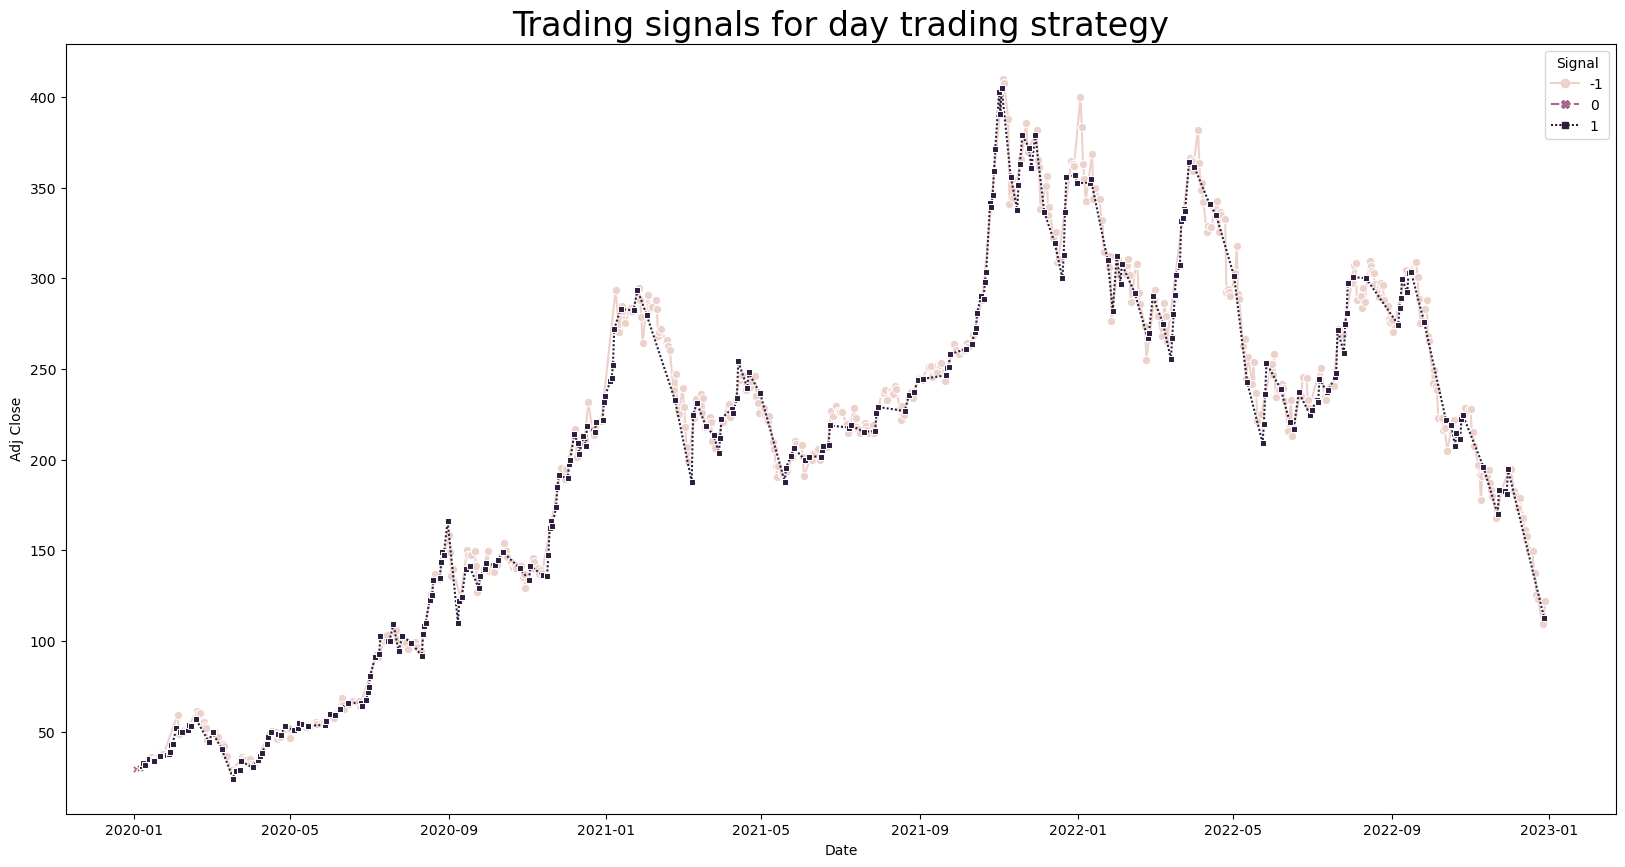

In [18]:
df_plot['Diff Close'] =  df_plot['Predicted Close'] - df_plot['Adj Close'] 
df_plot_pnl = df_plot.copy()
df_plot_pnl =  df_plot.drop(columns=['Diff Close','Profit','Predicted Close'],axis=1)
plt.figure(figsize = ( 20 , 10 ))
plt.title( 'Trading signals for day trading strategy' , size = 24 )
sns.lineplot(x="Date",y="Adj Close", hue='Signal', style="Signal", markers=True, data=df_plot_pnl)
  # Set title for figure

# sns.lineplot(x='Date', y='value', hue='Signal',markers=True, 
#              data=pd.melt(df_plot_pnl, ['Date','Signal']))




<AxesSubplot:title={'center':'Profits using Kalman Filter'}, xlabel='Date', ylabel='Profit'>

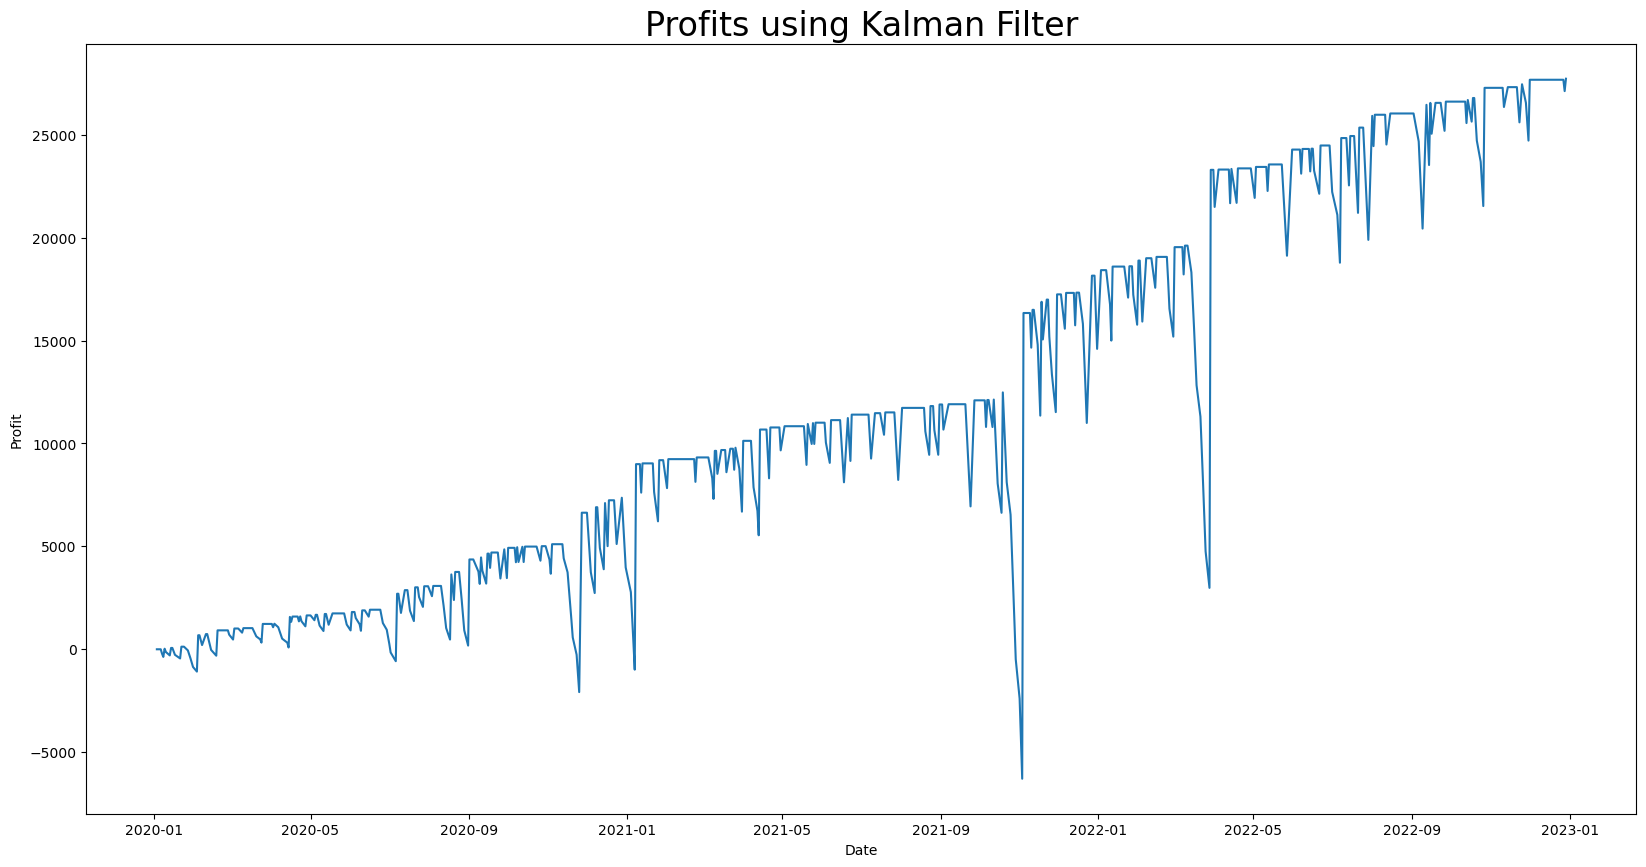

In [33]:
# df_plot_pnl =  df_plot[["Date","Profit"]]
df_plot.reset_index(drop=False)
df_plot.head()
plt.figure(figsize = ( 20 , 10 ))
plt.title( 'Profits using Kalman Filter' , size = 24 )
sns.lineplot(y="Profit",x=df_plot.index,data=df_plot )